<a href="https://colab.research.google.com/github/marah-awa/Fraud-Detection-Identifying-Credit-Card-Fraudulent-Transactions/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Dataset loaded successfully. Shape: (594643, 10)

Missing values:
 step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64


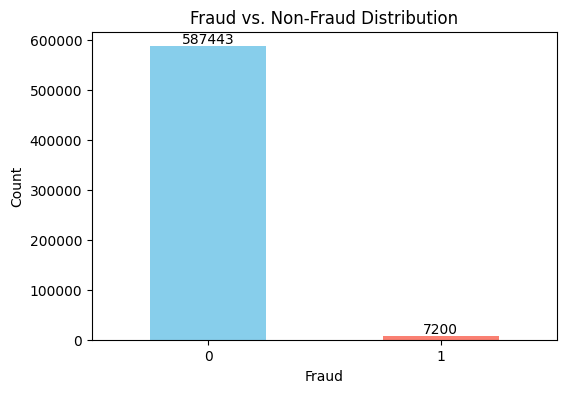

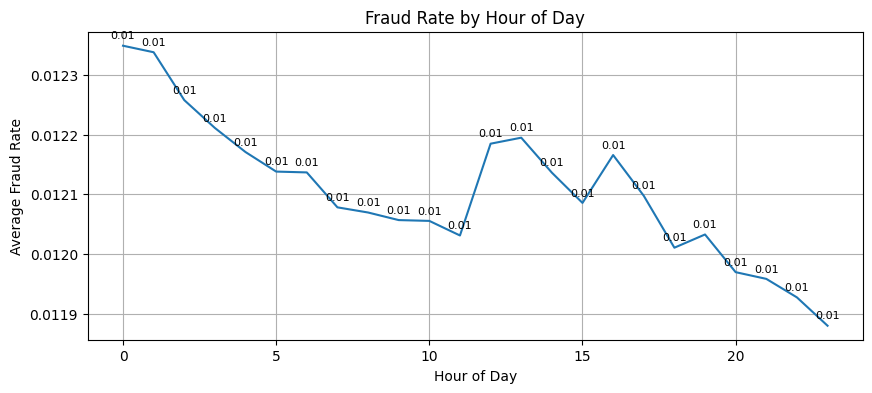


Data Split:
X_train: (475714, 34) X_test: (118929, 34)

Applying SMOTE to balance classes...
After SMOTE, class distribution:
fraud
0    469954
1    469954
Name: count, dtype: int64

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    117489
           1       0.16      0.98      0.27      1440

    accuracy                           0.94    118929
   macro avg       0.58      0.96      0.62    118929
weighted avg       0.99      0.94      0.96    118929

Logistic Regression ROC AUC: 0.9922
Logistic Regression F1 Score: 0.2715


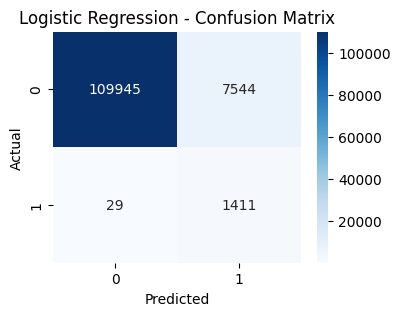


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    117489
           1       0.48      0.74      0.58      1440

    accuracy                           0.99    118929
   macro avg       0.74      0.86      0.79    118929
weighted avg       0.99      0.99      0.99    118929

Random Forest ROC AUC: 0.9725
Random Forest F1 Score: 0.5823


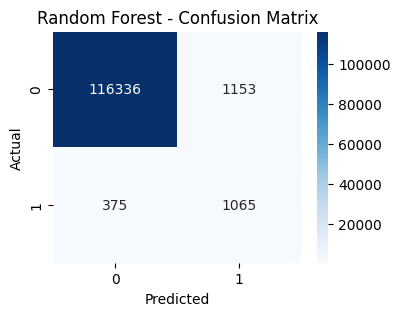


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    117489
           1       0.18      0.96      0.31      1440

    accuracy                           0.95    118929
   macro avg       0.59      0.95      0.64    118929
weighted avg       0.99      0.95      0.96    118929

Gradient Boosting ROC AUC: 0.9923
Gradient Boosting F1 Score: 0.3092


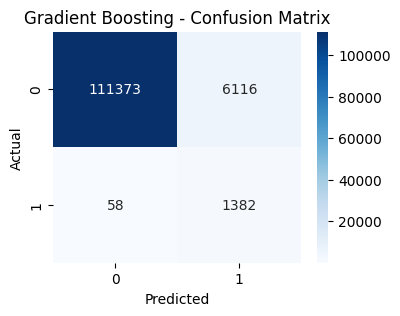

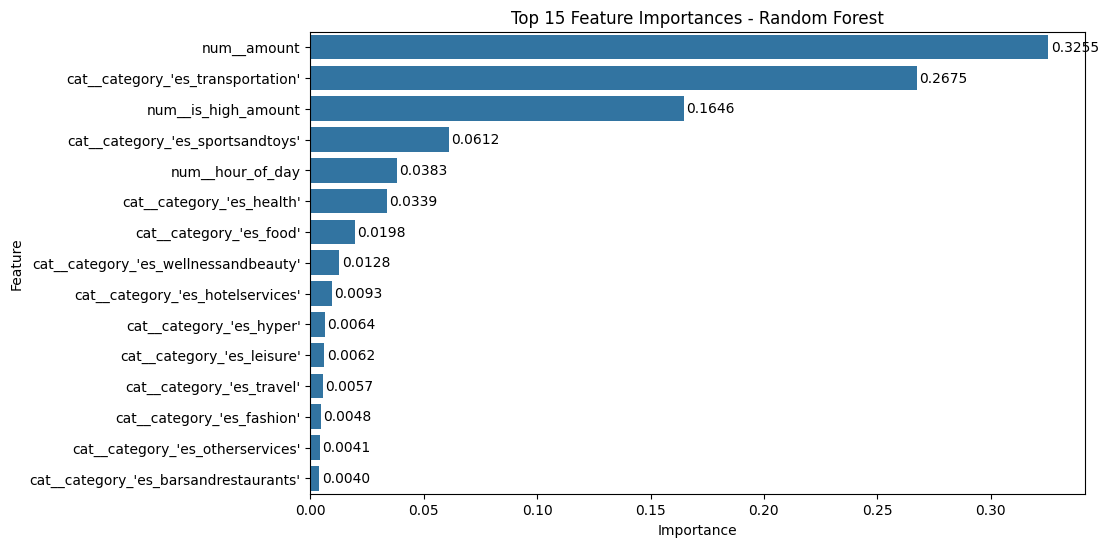


Top Important Features and Interpretation:
- num__amount: contributes to fraud detection with importance score 0.3255
- cat__category_'es_transportation': contributes to fraud detection with importance score 0.2675
- num__is_high_amount: contributes to fraud detection with importance score 0.1646
- cat__category_'es_sportsandtoys': contributes to fraud detection with importance score 0.0612
- num__hour_of_day: contributes to fraud detection with importance score 0.0383

These features may influence fraud detection due to their correlation with transaction behavior or customer patterns.

🔄 Running GridSearchCV (Light version)...
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 1.6min
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 1.6min
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time= 1.0min
[CV] END max_depth=10, min_samples_split=2, n_estimators=

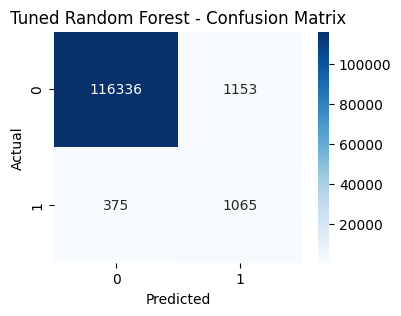


Models saved successfully.

Recommendations and Key Outcomes:
- Use models like Random Forest or Gradient Boosting for their high F1-score in imbalanced settings.
- Apply SMOTE to handle class imbalance, which significantly improved recall for the minority class.
- Focus on features such as 'amount', 'is_high_amount', and 'time_period' which are highly indicative of fraud.


In [10]:
# === Step 1: Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

# === Step 2: Load Dataset ===
df = pd.read_csv("/content/fraud.csv")
print("\nDataset loaded successfully. Shape:", df.shape)

# === Step 3: Data Preprocessing ===
print("\nMissing values:\n", df.isnull().sum())

# === Step 4: Feature Engineering ===
df["hour_of_day"] = df["step"] % 24

def map_time_period(hour):
    if 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 18:
        return "afternoon"
    elif 18 <= hour < 24:
        return "evening"
    else:
        return "night"

df["time_period"] = df["hour_of_day"].apply(map_time_period)

amount_threshold = df['amount'].quantile(0.95)
df['is_high_amount'] = (df['amount'] > amount_threshold).astype(int)

df.drop(columns=["step", "customer", "zipcodeOri", "merchant", "zipMerchant"], inplace=True)

# === Step 5: Exploratory Data Analysis (EDA) ===
plt.figure(figsize=(6, 4))
ax = df['fraud'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Fraud vs. Non-Fraud Distribution")
plt.xlabel("Fraud")
plt.ylabel("Count")
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')
plt.show()

plt.figure(figsize=(10, 4))
fraud_rate_by_hour = df.groupby('hour_of_day')['fraud'].mean().reset_index()
ax2 = sns.lineplot(x='hour_of_day', y='fraud', data=fraud_rate_by_hour)
plt.title("Fraud Rate by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Fraud Rate")
plt.grid(True)

for x, y in zip(fraud_rate_by_hour['hour_of_day'], fraud_rate_by_hour['fraud']):
    ax2.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)
plt.show()

# === Step 6: Feature Preparation ===
categorical_features = ["age", "gender", "category", "time_period"]
numerical_features = ["amount", "hour_of_day", "is_high_amount"]

X = df.drop("fraud", axis=1)
y = df["fraud"]

num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer([
    ("num", num_transformer, numerical_features),
    ("cat", cat_transformer, categorical_features)
])

pipeline = Pipeline(steps=[("preprocessor", preprocessor)])
X_processed = pipeline.fit_transform(X)
if hasattr(X_processed, "toarray"):
    X_processed = X_processed.toarray()

# === Step 7: Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y)

print("\nData Split:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)

# === Step 8: Handle Class Imbalance using SMOTE ===
print("\nApplying SMOTE to balance classes...")
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("After SMOTE, class distribution:")
print(pd.Series(y_train_res).value_counts())

# === Step 9: Model Training and Evaluation ===
def evaluate_model(name, model, X_test, y_test, y_pred, y_proba):
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"{name} ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"{name} F1 Score: {f1_score(y_test, y_pred):.4f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

log_model = LogisticRegression(solver="liblinear", class_weight="balanced", random_state=42)
log_model.fit(X_train_res, y_train_res)
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]
evaluate_model("Logistic Regression", log_model, X_test, y_test, y_pred_log, y_proba_log)

rf_model = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_model.fit(X_train_res, y_train_res)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
evaluate_model("Random Forest", rf_model, X_test, y_test, y_pred_rf, y_proba_rf)

gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_res, y_train_res)
y_pred_gb = gb_model.predict(X_test)
y_proba_gb = gb_model.predict_proba(X_test)[:, 1]
evaluate_model("Gradient Boosting", gb_model, X_test, y_test, y_pred_gb, y_proba_gb)

# === Step 10: Feature Importance and Interpretation ===
importances = rf_model.feature_importances_
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
feature_imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_imp_df = feature_imp_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Importance", y="Feature", data=feature_imp_df.head(15))
plt.title("Top 15 Feature Importances - Random Forest")
for i, (imp, feat) in enumerate(zip(feature_imp_df["Importance"].head(15), feature_imp_df["Feature"].head(15))):
    ax.text(imp + 0.001, i, f'{imp:.4f}', va='center')
plt.show()

print("\nTop Important Features and Interpretation:")
for i, row in feature_imp_df.head(5).iterrows():
    print(f"- {row['Feature']}: contributes to fraud detection with importance score {row['Importance']:.4f}")
print("\nThese features may influence fraud detection due to their correlation with transaction behavior or customer patterns.")

# === Step 11: GridSearchCV (Light Version) ===
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight="balanced"),
    param_grid=param_grid,
    scoring='f1',
    cv=2,
    n_jobs=1,
    verbose=2
)

print("\n🔄 Running GridSearchCV (Light version)...")
grid_search.fit(X_train_res, y_train_res)
best_rf_model = grid_search.best_estimator_

y_pred_best_rf = best_rf_model.predict(X_test)
y_proba_best_rf = best_rf_model.predict_proba(X_test)[:, 1]
evaluate_model("Tuned Random Forest", best_rf_model, X_test, y_test, y_pred_best_rf, y_proba_best_rf)

# === Step 12: Save Models ===
joblib.dump(log_model, "logistic_model.pkl")
joblib.dump(rf_model, "random_forest_model.pkl")
joblib.dump(gb_model, "gradient_boosting_model.pkl")
joblib.dump(best_rf_model, "best_random_forest_model.pkl")
print("\nModels saved successfully.")

# === Step 13: Business Recommendations ===
print("\nRecommendations and Key Outcomes:")
print("- Use models like Random Forest or Gradient Boosting for their high F1-score in imbalanced settings.")
print("- Apply SMOTE to handle class imbalance, which significantly improved recall for the minority class.")
print("- Focus on features such as 'amount', 'is_high_amount', and 'time_period' which are highly indicative of fraud.")